In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#Load the data
sheet_id = "1cNtByeuQJlR1diNc-mYHbUwNa--s-khcHGlvpFJJguk"
gid = "2022949602"
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

df = pd.read_csv(csv_url)

print(f"Original shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")


#Remove empty rows
df = df.dropna(how='all')
print(f"After removing empty rows: {df.shape[0]} rows")

#Clean the price column to make all the values numerical
if 'price' in df.columns:
    df['price'] = df['price'].astype(str).str.replace('$', '').str.replace(',', '').str.strip()
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df = df[df['price'] > 0]
    print(f"After cleaning price: {df.shape[0]} rows")

numeric_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
                'maximum_nights', 'number_of_reviews', 'review_scores_rating',
                'host_total_listings_count']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())

#Remove rows with missing critical data
required_cols = ['Borough', 'price', 'accommodates', 'bedrooms']
df = df.dropna(subset=required_cols)
df = df[df['minimum_nights'] > 0]
print(f"After removing N/A and zeros: {df.shape[0]} rows")


if len(df) < 50:
    raise ValueError(f"Not enough data! Only {len(df)} rows remaining.")

print(f"\nFinal dataset: {df.shape[0]} rows")

Original shape: (36111, 14)

Columns: ['host_total_listings_count', 'neighbourhood', 'Borough', 'property_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating']
After removing empty rows: 36111 rows
After cleaning price: 21328 rows
After removing N/A and zeros: 21328 rows

Final dataset: 21328 rows


In [ ]:

#Define our price thresholds based on quartiles for the categories
q25 = df['price'].quantile(0.25)
q50 = df['price'].quantile(0.50)
q75 = df['price'].quantile(0.75)

print(f"\nPrice distribution:")
print(f"  25th percentile (Q1): ${q25:.2f}")
print(f"  50th percentile (Median): ${q50:.2f}")
print(f"  75th percentile (Q3): ${q75:.2f}")
print(f"  Max: ${df['price'].max():.2f}")

#Create categories based on quartiles
def categorize_price(price):
    if price <= q25:
        return 0  #Cheap
    elif price <= q50:
        return 1  #Medium
    elif price <= q75:
        return 2  #Expensive
    else:
        return 3  #Ultra Expensive

df['price_category'] = df['price'].apply(categorize_price)

#Create category labels
category_labels = {0: 'Cheap', 1: 'Medium', 2: 'Expensive', 3: 'Ultra Expensive'}
category_ranges = {
    0: f'$0 - ${q25:.2f}',
    1: f'${q25:.2f} - ${q50:.2f}',
    2: f'${q50:.2f} - ${q75:.2f}',
    3: f'${q75:.2f}+'
}

print("\nPrice Categories:")
for cat, label in category_labels.items():
    count = (df['price_category'] == cat).sum()
    percentage = (count / len(df)) * 100
    print(f"  {cat}: {label:15} {category_ranges[cat]:20} - {count:5} listings ({percentage:.1f}%)")



Price distribution:
  25th percentile (Q1): $89.00
  50th percentile (Median): $154.00
  75th percentile (Q3): $279.00
  Max: $50104.00

Price Categories:
  0: Cheap           $0 - $89.00          -  5363 listings (25.1%)
  1: Medium          $89.00 - $154.00     -  5326 listings (25.0%)
  2: Expensive       $154.00 - $279.00    -  5320 listings (24.9%)
  3: Ultra Expensive $279.00+             -  5319 listings (24.9%)


In [ ]:
#Encode the categorical variables
le_borough = LabelEncoder()
df['borough_encoded'] = le_borough.fit_transform(df['Borough'])

if 'property_type' in df.columns:
    le_property = LabelEncoder()
    df['property_type_encoded'] = le_property.fit_transform(df['property_type'])
else:
    df['property_type_encoded'] = 0

if 'neighbourhood' in df.columns:
    le_neighbourhood = LabelEncoder()
    df['neighbourhood_encoded'] = le_neighbourhood.fit_transform(df['neighbourhood'])
else:
    df['neighbourhood_encoded'] = 0

#Create engineered features
df['total_capacity'] = df['accommodates'] * df['bedrooms']
df['bathroom_per_bedroom'] = df['bathrooms'] / (df['bedrooms'] + 1)  # +1 to avoid division by zero
df['beds_per_bedroom'] = df['beds'] / (df['bedrooms'] + 1)

#Log transform for skewed features
df['log_minimum_nights'] = np.log1p(df['minimum_nights'])
df['log_maximum_nights'] = np.log1p(df['maximum_nights'])
df['log_reviews'] = np.log1p(df['number_of_reviews'])
df['log_host_listings'] = np.log1p(df['host_total_listings_count'])

#Review quality indicator
df['has_reviews'] = (df['number_of_reviews'] > 0).astype(int)
df['review_quality'] = df['review_scores_rating'] / 100  # Normalize to 0-1


print(f"\nDataset statistics:")
print(f"  Accommodates range: {df['accommodates'].min():.0f} - {df['accommodates'].max():.0f}")
print(f"  Bedrooms range: {df['bedrooms'].min():.0f} - {df['bedrooms'].max():.0f}")
print(f"  Average review score: {df['review_scores_rating'].mean():.2f}")
print(f"  Properties with reviews: {df['has_reviews'].sum()} ({df['has_reviews'].mean()*100:.1f}%)")


Dataset statistics:
  Accommodates range: 1 - 16
  Bedrooms range: 0 - 16
  Average review score: 4.77
  Properties with reviews: 14944 (70.1%)


In [ ]:
feature_cols = [
    'borough_encoded',
    'property_type_encoded',
    'neighbourhood_encoded',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews',
    'review_scores_rating',
    'host_total_listings_count',
    'total_capacity',
    'bathroom_per_bedroom',
    'beds_per_bedroom',
    'log_minimum_nights',
    'log_maximum_nights',
    'log_reviews',
    'log_host_listings',
    'has_reviews',
    'review_quality'
]
X = df[feature_cols].values
y = df['price_category'].values

print(f"Features: {len(feature_cols)}")
print(f"Samples: {len(X)}")
print(f"Classes: {len(np.unique(y))}")

#Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Use StandardScaler
scaler_X = StandardScaler()
X_train_norm = scaler_X.fit_transform(X_train)
X_test_norm = scaler_X.transform(X_test)

print(f"\nTraining set: {X_train_norm.shape[0]} samples")
print(f"Test set: {X_test_norm.shape[0]} samples")

#Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

#Create DataLoader for batch training
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Features: 21
Samples: 21328
Classes: 4

Training set: 17062 samples
Test set: 4266 samples


In [ ]:
input_size = X_train_norm.shape[1]
num_classes = 4
dropout_rate = 0.4

model = nn.Sequential(
    nn.Linear(input_size, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(dropout_rate),

    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(dropout_rate),

    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(dropout_rate),

    nn.Linear(64, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(dropout_rate),

    nn.Linear(32, num_classes))

print(f"  Input size: {input_size}")
print(f"  Hidden layers: [256, 128, 64, 32]")
print(f"  Output classes: {num_classes}")
print(f"  Dropout rate: {dropout_rate}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters())}")


#Loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

#Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

  Input size: 21
  Hidden layers: [256, 128, 64, 32]
  Output classes: 4
  Dropout rate: 0.4
  Total parameters: 49956


In [ ]:
#Train model and prevent overfitting


epochs = 300
train_losses = []
train_accuracies = []
best_loss = float('inf')
patience = 30
patience_counter = 0

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    #Batch training
    for batch_X, batch_y in train_loader:
        #Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        #Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        epoch_loss += loss.item()

    #Average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    #Learning rate scheduling
    scheduler.step(avg_loss)

    #Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        #Save best model
        best_model_state = model.state_dict()
    else:
        patience_counter += 1

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {train_acc:.4f}")

    #Early stopping check
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch + 1}")
        model.load_state_dict(best_model_state)  # Load best model
        break

Epoch [20/300], Loss: 0.8750, Accuracy: 0.6175
Epoch [40/300], Loss: 0.8481, Accuracy: 0.6287
Epoch [60/300], Loss: 0.8314, Accuracy: 0.6400
Epoch [80/300], Loss: 0.8217, Accuracy: 0.6430
Epoch [100/300], Loss: 0.8021, Accuracy: 0.6527
Epoch [120/300], Loss: 0.7949, Accuracy: 0.6544
Epoch [140/300], Loss: 0.7949, Accuracy: 0.6525
Epoch [160/300], Loss: 0.7918, Accuracy: 0.6520
Epoch [180/300], Loss: 0.7843, Accuracy: 0.6576
Epoch [200/300], Loss: 0.7788, Accuracy: 0.6643
Epoch [220/300], Loss: 0.7710, Accuracy: 0.6648
Epoch [240/300], Loss: 0.7723, Accuracy: 0.6647

Early stopping triggered at epoch 257


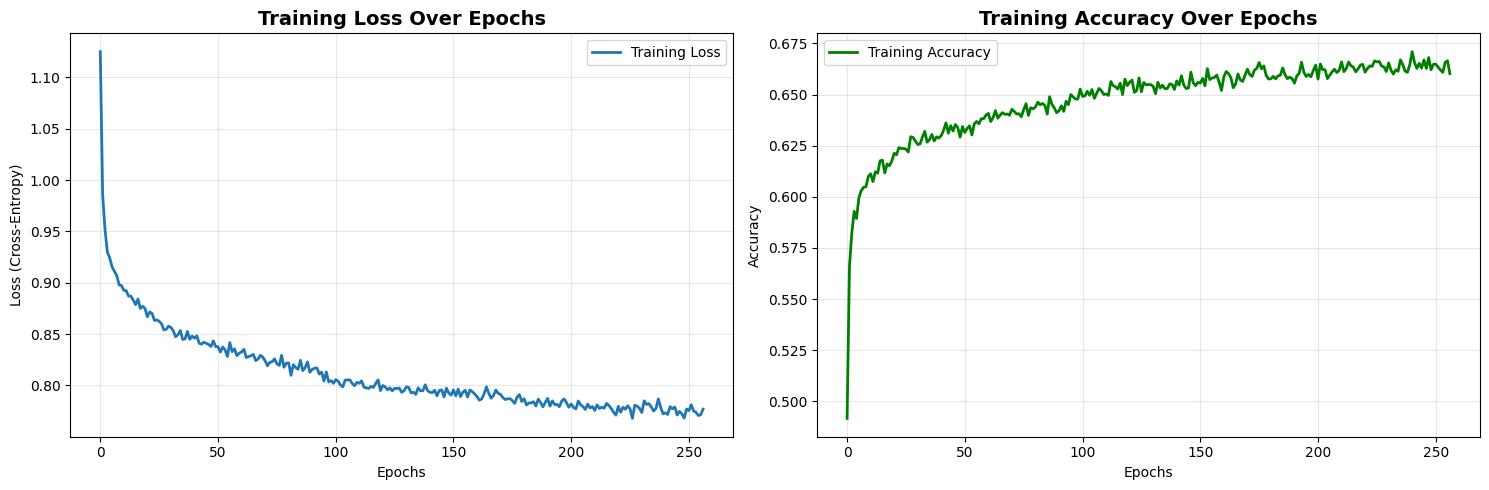

In [ ]:


#Plotting our training metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", linewidth=2)
ax1.set_title("Training Loss Over Epochs", fontsize=14, fontweight='bold')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss (Cross-Entropy)")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color='green', linewidth=2)
ax2.set_title("Training Accuracy Over Epochs", fontsize=14, fontweight='bold')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Test Accuracy: 0.6528 (65.28%)

Classification Report:
                               precision    recall  f1-score   support

          Cheap ($0 - $89.00)       0.75      0.85      0.79      1073
    Medium ($89.00 - $154.00)       0.52      0.55      0.53      1065
Expensive ($154.00 - $279.00)       0.52      0.54      0.53      1064
   Ultra Expensive ($279.00+)       0.86      0.67      0.76      1064

                     accuracy                           0.65      4266
                    macro avg       0.66      0.65      0.65      4266
                 weighted avg       0.66      0.65      0.65      4266


Per-Class Accuracy:
  Cheap          : 0.8481 (84.81%)
  Medium         : 0.5465 (54.65%)
  Expensive      : 0.5404 (54.04%)
  Ultra Expensive: 0.6748 (67.48%)


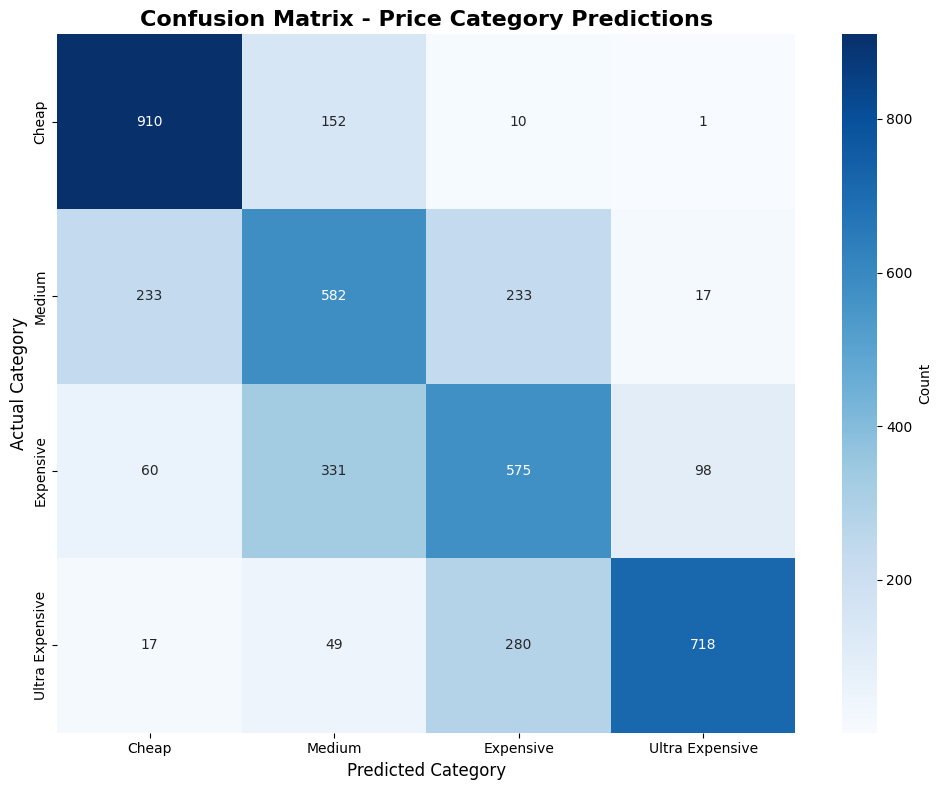

In [ ]:
#model evaluation
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_tensor)
    _, y_pred = torch.max(y_pred_logits, 1)

y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

#Calculate metrics
accuracy = accuracy_score(y_test_np, y_pred_np)
print(f"\nTest Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_np,
                          target_names=[f"{label} ({category_ranges[i]})"
                                      for i, label in category_labels.items()]))

#Per-class accuracy
print("\nPer-Class Accuracy:")
cm = confusion_matrix(y_test_np, y_pred_np)
for i, label in category_labels.items():
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"  {label:15}: {class_acc:.4f} ({class_acc*100:.2f}%)")

#plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[category_labels[i] for i in range(4)],
            yticklabels=[category_labels[i] for i in range(4)],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Price Category Predictions', fontsize=16, fontweight='bold')
plt.ylabel('Actual Category', fontsize=12)
plt.xlabel('Predicted Category', fontsize=12)
plt.tight_layout()
plt.show()

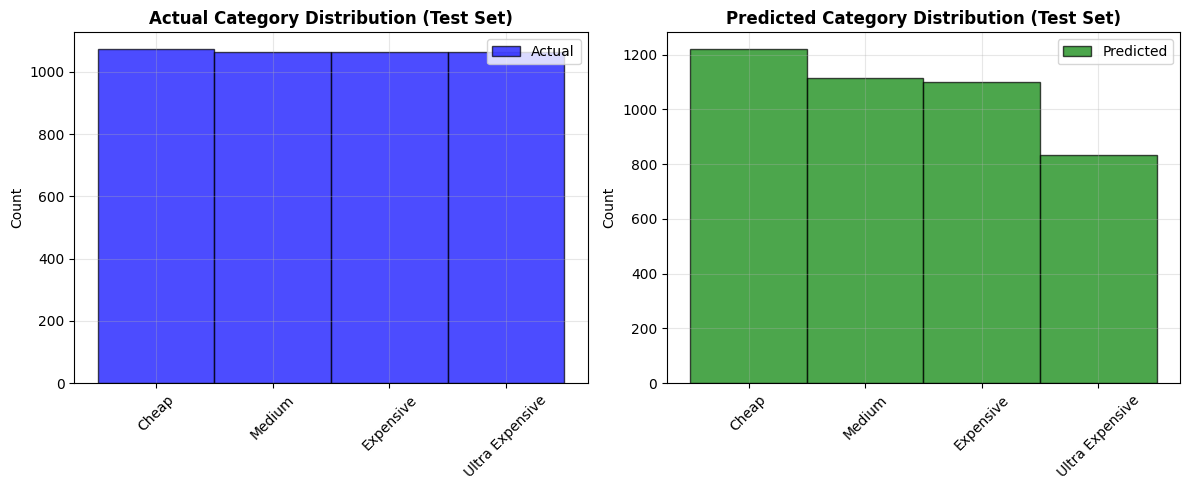

Final Test Accuracy: 65.28%


In [ ]:
#prediction distribution plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_test_np, bins=np.arange(5)-0.5, alpha=0.7, label='Actual', color='blue', edgecolor='black')
plt.xticks(range(4), [category_labels[i] for i in range(4)], rotation=45)
plt.title('Actual Category Distribution (Test Set)', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(y_pred_np, bins=np.arange(5)-0.5, alpha=0.7, label='Predicted', color='green', edgecolor='black')
plt.xticks(range(4), [category_labels[i] for i in range(4)], rotation=45)
plt.title('Predicted Category Distribution (Test Set)', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Test Accuracy: {accuracy*100:.2f}%")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Test accuracy of the random forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
rf_model.fit(X_train_norm, y_train)
y_pred_rf = rf_model.predict(X_test_norm)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Test Accuracy: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")


Random Forest Test Accuracy: 0.6721 (67.21%)



Top 10 Most Important Features (Random Forest):
  property_type_encoded          0.1194
  neighbourhood_encoded          0.0796
  host_total_listings_count      0.0751
  log_host_listings              0.0751
  accommodates                   0.0750
  number_of_reviews              0.0533
  log_reviews                    0.0531
  minimum_nights                 0.0445
  borough_encoded                0.0440
  total_capacity                 0.0437


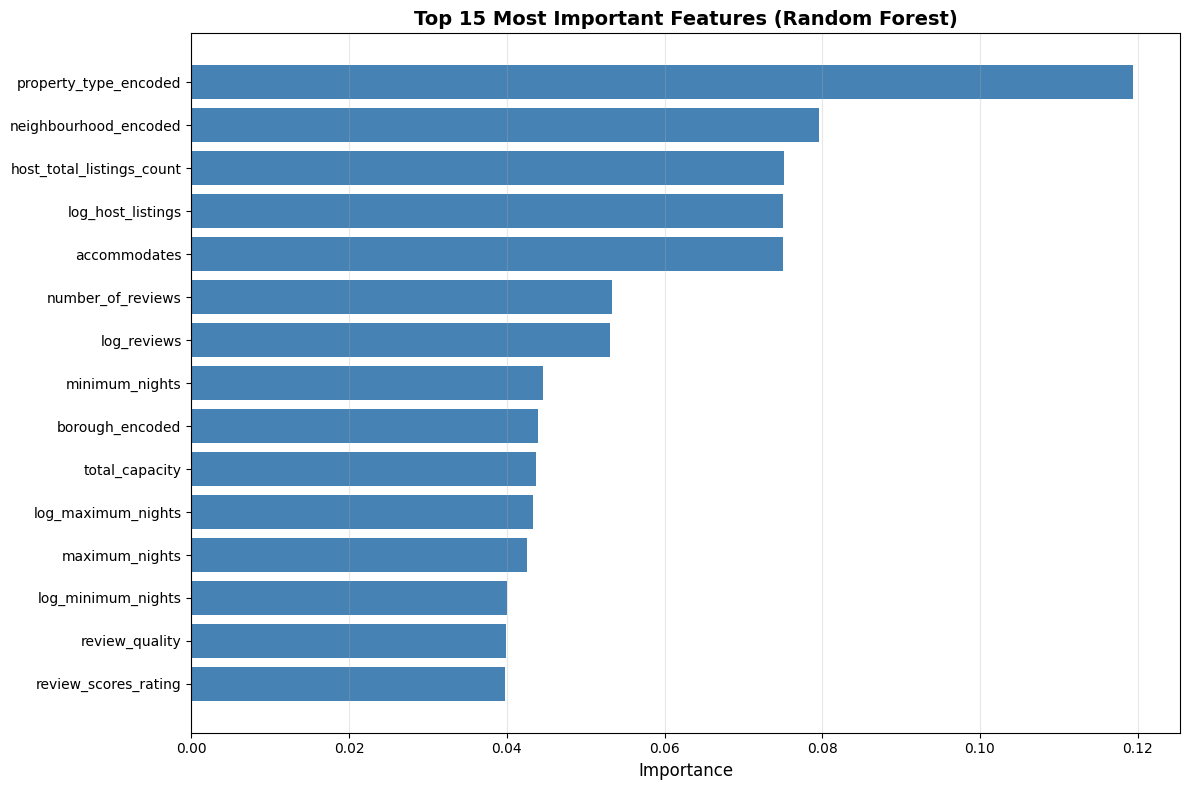

In [ ]:
#Feature Importance from Random Forest
feature_importance_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Random Forest):")
for idx, row in feature_importance_rf.head(10).iterrows():
    print(f"  {row['feature']:30} {row['importance']:.4f}")


#Feature Importance Plot
plt.figure(figsize=(12, 8))
top_features = feature_importance_rf.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


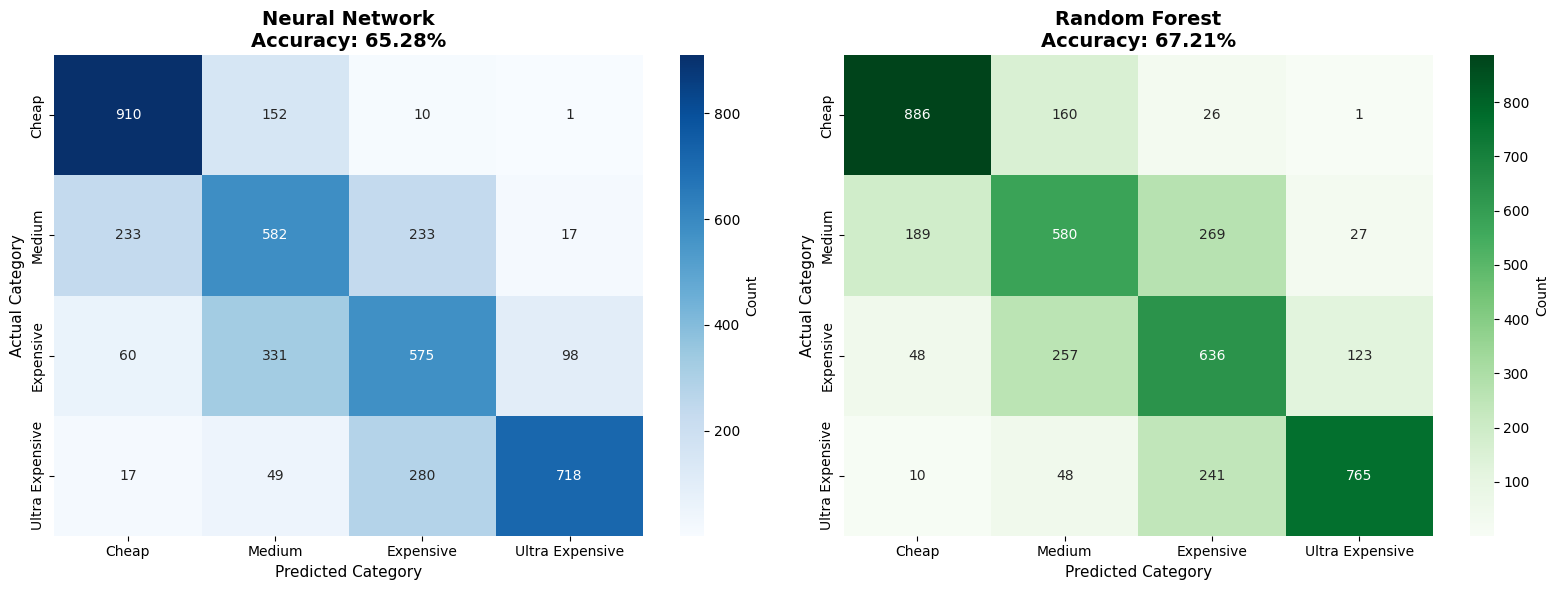

In [ ]:
#Confusion matrics of both models side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=[category_labels[i] for i in range(4)],
            yticklabels=[category_labels[i] for i in range(4)],
            cbar_kws={'label': 'Count'})
ax1.set_title(f'Neural Network\nAccuracy: {accuracy*100:.2f}%', fontsize=14, fontweight='bold')
ax1.set_ylabel('Actual Category', fontsize=11)
ax1.set_xlabel('Predicted Category', fontsize=11)

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=[category_labels[i] for i in range(4)],
            yticklabels=[category_labels[i] for i in range(4)],
            cbar_kws={'label': 'Count'})
ax2.set_title(f'Random Forest\nAccuracy: {rf_accuracy*100:.2f}%', fontsize=14, fontweight='bold')
ax2.set_ylabel('Actual Category', fontsize=11)
ax2.set_xlabel('Predicted Category', fontsize=11)

plt.tight_layout()
plt.show()

In [ ]:
#Compare Models
#Per-class accuracy comparison
print("\nPer-Class Accuracy Comparison:")
cm_nn = confusion_matrix(y_test_np, y_pred_np)
cm_rf = confusion_matrix(y_test, y_pred_rf)

for i, label in category_labels.items():
    nn_class_acc = cm_nn[i, i] / cm_nn[i].sum() if cm_nn[i].sum() > 0 else 0
    rf_class_acc = cm_rf[i, i] / cm_rf[i].sum() if cm_rf[i].sum() > 0 else 0
    print(f"  {label:15} - NN: {nn_class_acc*100:.2f}%, RF: {rf_class_acc*100:.2f}%")


print("\nModel Comparison")
print(f"Neural Network Accuracy: {accuracy*100:.2f}%")
print(f"Random Forest Accuracy:  {rf_accuracy*100:.2f}%")
print(f"\nBest Model: {'Neural Network' if accuracy > rf_accuracy else 'Random Forest'}")



Per-Class Accuracy Comparison:
  Cheap           - NN: 84.81%, RF: 82.57%
  Medium          - NN: 54.65%, RF: 54.46%
  Expensive       - NN: 54.04%, RF: 59.77%
  Ultra Expensive - NN: 67.48%, RF: 71.90%

Model Comparison
Neural Network Accuracy: 65.28%
Random Forest Accuracy:  67.21%

Best Model: Random Forest


In [ ]:
#Borough encoding mapping
borough_mapping = dict(zip(le_borough.classes_, le_borough.transform(le_borough.classes_)))

print("\nBorough Encoding Mapping:")
for borough, code in borough_mapping.items():
    print(f"  {borough}: {code}")


Borough Encoding Mapping:
  Bronx: 0
  Brooklyn: 1
  Manhattan: 2
  Queens: 3
  Staten Island: 4


In [ ]:
#Neighbourhood encoding mapping
neighbourhood_mapping = dict(
    zip(le_neighbourhood.classes_,
        le_neighbourhood.transform(le_neighbourhood.classes_)))

print("\nNeighbourhood Encoding Mapping:")
for neighbourhood, code in neighbourhood_mapping.items():
    print(f"  {neighbourhood}: {code}")



Neighbourhood Encoding Mapping:
  Allerton: 0
  Arden Heights: 1
  Arrochar: 2
  Arverne: 3
  Astoria: 4
  Bath Beach: 5
  Battery Park City: 6
  Bay Ridge: 7
  Bay Terrace: 8
  Bay Terrace, Staten Island: 9
  Baychester: 10
  Bayside: 11
  Bayswater: 12
  Bedford-Stuyvesant: 13
  Belle Harbor: 14
  Bellerose: 15
  Belmont: 16
  Bensonhurst: 17
  Bergen Beach: 18
  Boerum Hill: 19
  Borough Park: 20
  Breezy Point: 21
  Briarwood: 22
  Brighton Beach: 23
  Bronxdale: 24
  Brooklyn Heights: 25
  Brownsville: 26
  Bull's Head: 27
  Bushwick: 28
  Cambria Heights: 29
  Canarsie: 30
  Carroll Gardens: 31
  Castle Hill: 32
  Castleton Corners: 33
  Chelsea: 34
  Chelsea, Staten Island: 35
  Chinatown: 36
  City Island: 37
  Civic Center: 38
  Claremont Village: 39
  Clason Point: 40
  Clifton: 41
  Clinton Hill: 42
  Co-op City: 43
  Cobble Hill: 44
  College Point: 45
  Columbia St: 46
  Concord: 47
  Concourse: 48
  Concourse Village: 49
  Coney Island: 50
  Corona: 51
  Country Club: 52

In [ ]:
#Creating a random but realistic listing for us to use our model on
#Want to find where we should price this theoretical listing

print("\nPrice range prediction for our listing:")

random_listing = {
    'borough_encoded': np.random.randint(0, df['borough_encoded'].nunique()),
    'property_type_encoded': np.random.randint(0, df['property_type_encoded'].nunique()),
    'neighbourhood_encoded': np.random.randint(0, df['neighbourhood_encoded'].nunique()),
    'accommodates': np.random.randint(1, 8),
    'bathrooms': np.random.randint(1, 3),
    'bedrooms': np.random.randint(1, 4),
    'beds': np.random.randint(1, 5),
    'minimum_nights': np.random.randint(1, 5),
    'maximum_nights': np.random.randint(7, 180),
    'number_of_reviews': np.random.randint(0, 300),
    'review_scores_rating': np.random.uniform(0, 5),
    'host_total_listings_count': np.random.randint(1, 20)}

#Convert to DataFrame
random_df = pd.DataFrame([random_listing])

#Recreate engineered features
random_df['total_capacity'] = random_df['accommodates'] * random_df['bedrooms']
random_df['bathroom_per_bedroom'] = random_df['bathrooms'] / (random_df['bedrooms'] + 1)
random_df['beds_per_bedroom'] = random_df['beds'] / (random_df['bedrooms'] + 1)
random_df['log_minimum_nights'] = np.log1p(random_df['minimum_nights'])
random_df['log_maximum_nights'] = np.log1p(random_df['maximum_nights'])
random_df['log_reviews'] = np.log1p(random_df['number_of_reviews'])
random_df['log_host_listings'] = np.log1p(random_df['host_total_listings_count'])
random_df['has_reviews'] = (random_df['number_of_reviews'] > 0).astype(int)
random_df['review_quality'] = random_df['review_scores_rating'] / 100

#Keep column order consistent
random_X = random_df[feature_cols].values

#Scale using trained scaler
random_X_scaled = scaler_X.transform(random_X)

#Predict with Random Forest since that was our more accurate model
predicted_class = rf_model.predict(random_X_scaled)[0]

print("\nRandom Airbnb Listing Details:")
for k, v in random_listing.items():
    print(f"  {k}: {v}")

print("\nPredicted Price Category:")
print(f"  {category_labels[predicted_class]} ({category_ranges[predicted_class]})")



Price range prediction for our listing:

Random Airbnb Listing Details:
  borough_encoded: 4
  property_type_encoded: 16
  neighbourhood_encoded: 85
  accommodates: 3
  bathrooms: 1
  bedrooms: 2
  beds: 2
  minimum_nights: 3
  maximum_nights: 96
  number_of_reviews: 281
  review_scores_rating: 4.662909454154769
  host_total_listings_count: 15

Predicted Price Category:
  Expensive ($154.00 - $279.00)
